# 1. Multi-Armed Bandit

## Aufgabe 1.1: Der K-armige Bandit

Imports:

In [8]:
import random
import numpy as np

Create a distribution super class so that we can implement different kinds of distributions later on:

In [9]:
from abc import ABC, abstractmethod

class Distribution(ABC):
    
    @abstractmethod
    def __init__(self, *args):
        pass
    
    @abstractmethod
    def get_value(self):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def get_name(self):
        pass

Based on the super class, create two specific distributions, the Bernoulli and Normal Distribution:

In [10]:
class BernoulliDistribution(Distribution):
    def __init__(self, *args):
        if len(args) == 1:
            self.p = args[0]
        else:
            self.p = round(random.random(), 1)


    def get_value(self):
        """
        Returns 1 with probability p, which has been instantiated randomly
        """
        random_value = random.random()
        hit = random_value < self.p
        return float(hit)
    
    def get_params(self):
        return [self.p]
    
    def get_name(self):
        return 'Bernoulli'

In [12]:
class NormalDistribution(Distribution):
    def __init__(self, *args):
        if len(args) == 2:
            self.mean = args[0]
            self.standard_deviation = args[1]
        else:
            self.mean = random.uniform(1, 5)
            self.standard_deviation = random.uniform(0.2, 3)

    def get_value(self):
        return np.random.normal(self.mean, self.standard_deviation)
    
    def get_params(self):
        return [self.mean, self.standard_deviation]
    
    def get_name(self):
        return 'Normal'


Now, create the bandit:

In [13]:
class kArmedBandit(object):
    
    def __init__(self, epsilon : float, arms : list):
        
        self.initial_epsilon = epsilon
        self.arms = arms

        k = len(arms)

        self.Q = np.zeros(k)
        self.N = np.zeros(k)

        self.G = 0
        self.regret = 0

        self.true_expected_values = [dist.get_params()[0] for dist in arms]
        self.a_star_index = np.argmax(self.true_expected_values)
        self.num_picks_a_star = 0

        print(f'Initialized bandit using {arms[0].get_name()} distribution, initial epsilon: {self.initial_epsilon}, true expected values: {np.round(self.true_expected_values, 1)}')

        self.first_pick = True

    def get_new_epsilon(self, num_picks : int):
        """
        Get a new value for epsilon. If you don't want to change epsilon, just type return self.initial_epsilon
        """
        #return self.initial_epsilon * np.exp(-0.003*num_picks)
        return self.initial_epsilon

    def pick(self, verbose = 0):
        
        # decide on explore vs exploit
        index = int(round(random.uniform(0, len(self.arms)-1), 0))

        epsilon = self.get_new_epsilon(np.sum(self.N))
        exploit = (random.random() > epsilon)
        if exploit and not self.first_pick:
            index = np.argmax(self.Q)

        self.first_pick = False

        # update percentual best hit
        if index == self.a_star_index:
            self.num_picks_a_star += 1

        # check whether we got a hit
        a = self.arms[index]
        R = a.get_value()
        
        # update cumulative metrics
        self.G += R
        self.regret += self.true_expected_values[self.a_star_index] - self.true_expected_values[index]

        # update Q
        self.N[index] += 1
        self.Q[index] = self.Q[index] + 1/self.N[index] * (R - self.Q[index])

        if verbose >= 1:
            print(f'Picked from arm {index} and got reward {R}, Exploited: {exploit}')
            if verbose >= 2:
                print(f'Q: {self.Q}, \nN: {self.N}')
            print('-'*10)


        return self.regret, self.G, self.num_picks_a_star / np.sum(self.N), self.G / np.sum(self.N)
    


Create a list of distributions, the bandits "arms":

In [14]:
k = 4
#arms = [NormalDistribution() for _ in range(k)]
arms = [NormalDistribution(2.62, 2.78),
        NormalDistribution(1.35, 0.93),
        NormalDistribution(4.62, 2.19),
        NormalDistribution(3.31, 1.28)]
epsilon_values = [0.01, 0.1, 0.2]

Now create multiple bandits with different epsilon-values and let them pick:

In [19]:
bandits = [kArmedBandit(epsilon, arms) for epsilon in epsilon_values]

num_rolls = 1000

averaged_cumulative_regret = []
averaged_cumulative_reward = []
averaged_percentual_best_pick = []

num_runs = 10

for i in range(num_runs):
    cumulative_regret = [[] for _ in bandits]
    cumulative_reward = [[] for _ in bandits]
    percentual_best_pick = [[] for _ in bandits]

    for _ in range(num_rolls):
        for bandit_index in range(len(bandits)):
            bandit = bandits[bandit_index]
            regret, G, current_percentual_best_pick, avg_reward = bandit.pick(verbose = 0)
            
            cumulative_regret[bandit_index].append(regret)
            cumulative_reward[bandit_index].append(G)
            percentual_best_pick[bandit_index].append(current_percentual_best_pick)
    
    averaged_cumulative_regret.append(cumulative_regret)
    averaged_cumulative_reward.append(cumulative_reward)
    averaged_percentual_best_pick.append(percentual_best_pick)


averaged_cumulative_regret = np.average(averaged_cumulative_regret, axis=0)
averaged_cumulative_reward = np.average(averaged_cumulative_reward, axis=0)
averaged_percentual_best_pick = np.average(averaged_percentual_best_pick, axis=0)

Initialized bandit using Normal distribution, initial epsilon: 0.01, true expected values: [2.6 1.4 4.6 3.3]
Initialized bandit using Normal distribution, initial epsilon: 0.1, true expected values: [2.6 1.4 4.6 3.3]
Initialized bandit using Normal distribution, initial epsilon: 0.2, true expected values: [2.6 1.4 4.6 3.3]


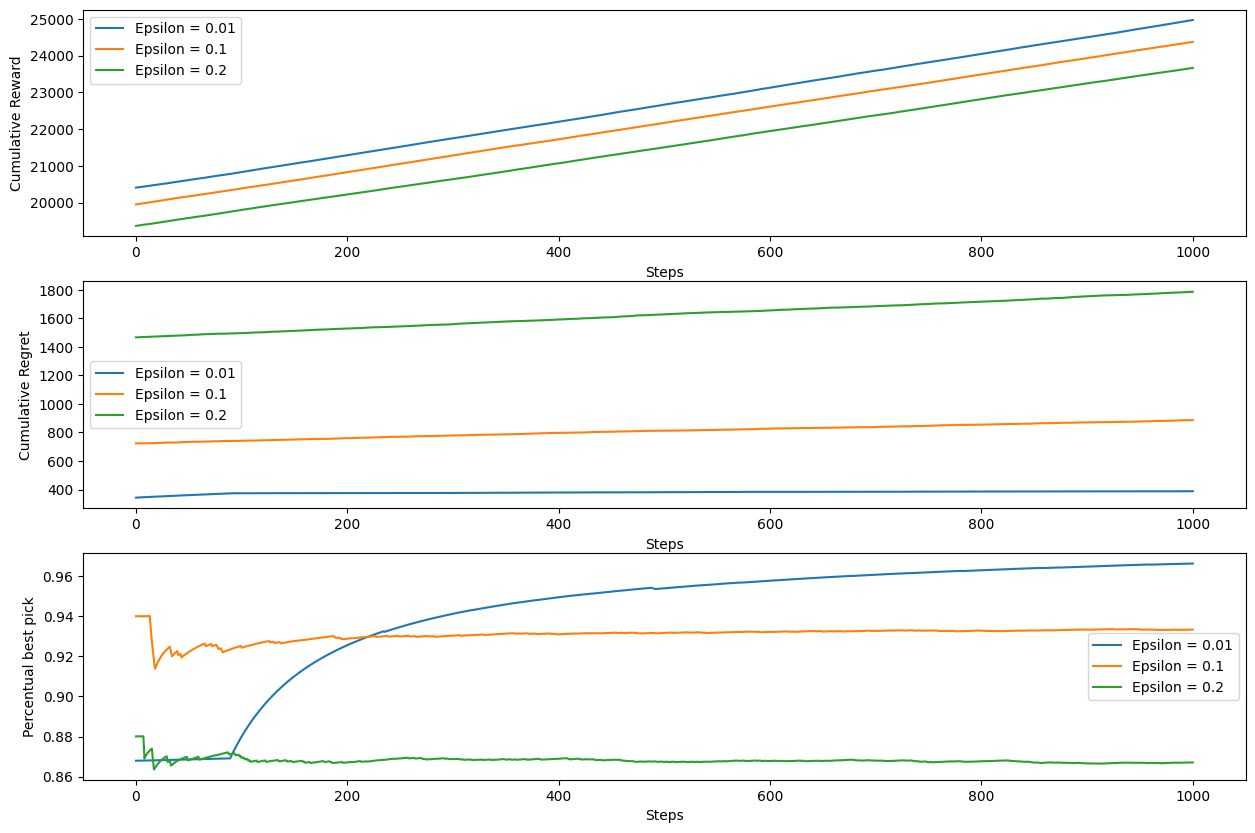

In [20]:
import matplotlib.pyplot as plt

t = np.linspace(0, num_rolls, num_rolls)

fig, ax = plt.subplots(3, figsize=(15,10))

for bandit_index in range(len(bandits)):
    ax[0].plot(t, averaged_cumulative_reward[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')
    ax[1].plot(t, averaged_cumulative_regret[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')
    ax[2].plot(t, averaged_percentual_best_pick[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')

ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Cumulative Reward')
ax[0].legend()

ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Cumulative Regret')
ax[1].legend()

ax[2].set_xlabel('Steps')
ax[2].set_ylabel('Percentual best pick')
ax[2].legend()


In [7]:
for arm in arms:
    print(np.round(arm.get_params(), 2))

[2.62 2.78]
[1.35 0.93]
[4.62 2.19]
[3.31 1.28]
